In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
sys.path.append('/home/hrai/codes/hpe_library/')
from lib_import import *
from my_utils import *

import ipywidgets as widgets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def calculate_azimuth_elevation(vector, root_R, degrees=False, multi_sol=False):
    x, y, z = root_R.T @ vector # express vector wrt rotated fram
    azim1 = math.atan2(y, x)
    elev1 = math.atan2(z, math.sqrt(x**2 + y**2))

    if y >= 0: 
        azim2 = azim1 - math.pi
        if z >= 0: elev2 = math.pi - elev1
        else: elev2 = -(math.pi + elev1)
    else:
        azim2 = azim1 + math.pi
        if z >= 0: elev2 = math.pi - elev1
        else: elev2 = -(math.pi + elev1)

    if degrees:
        azim1, elev1, azim2, elev2 = math.degrees(azim1), math.degrees(elev1), math.degrees(azim2), math.degrees(elev2)
    
    if multi_sol:
        return azim1, elev1, azim2, elev2  # Converting to degrees for readability
    else:
        return azim1, elev1

In [10]:
class azim_elev_analysis():
    def __init__(self):
        self.azim_slider = widgets.IntSlider(
            value=-90,
            min=-180,
            max=180,
            step=1,
            description='azim:',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

        elev_slider = widgets.IntSlider(
            value=0,
            min=-180,
            max=180,
            step=1,
            description='elev:',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

1.0 0.0 0.0


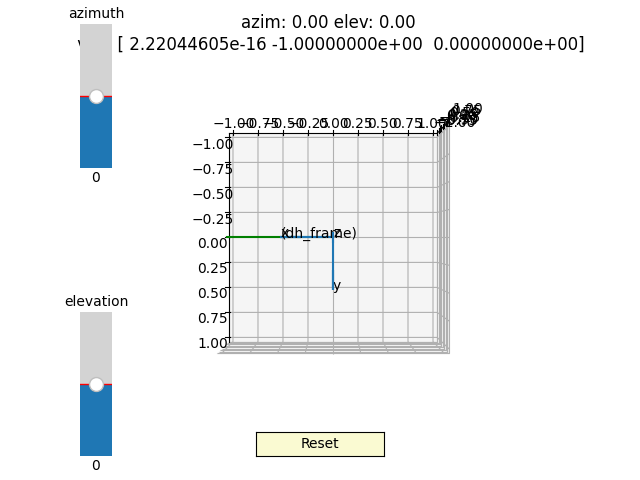

In [23]:
from matplotlib.widgets import Slider, Button

%matplotlib widget
fig = plt.figure(393)
fig.clear()
ax = axes_3d(fig, view=(90, 0))
set_xyzlim3d([-1, 1])
generate_world_frame().draw3d()

ax_azim = fig.add_axes([0.1, 0.65, 0.1, 0.3])
ax_elev = fig.add_axes([0.1, 0.05, 0.1, 0.3])
ax_reset = fig.add_axes([0.4, 0.05, 0.2, 0.05])

s_azim = Slider(ax = ax_azim, label = 'azimuth', valmin = -180, valmax = 180, valinit = 0, orientation="vertical")
s_elev = Slider(ax = ax_elev, label = 'elevation', valmin = -90, valmax = 90, valinit = 0, orientation="vertical")
button = Button(ax_reset, 'Reset', color='lightgoldenrodyellow', hovercolor='0.975')

prev_azim = 0
prev_elev = 0
Rot_z_minus_90 = Rotation.from_rotvec(-np.pi/2 * np.array([0, 0, 1])).as_matrix()
root_R = Rot_z_minus_90
root_frame = generate_vis_frame([0,0,0], root_R)

def update(val):
    global prev_azim, prev_elev
    # update joint angles
    azim = s_azim.val
    elev = s_elev.val
    
    vec = azim_elev_to_vec(azim, elev, degrees=True) # wrt local frame
    vec = Rot_z_minus_90 @ vec # rotate the vector / expressed wrt world frame
    
    # update plot
    azim = ax.azim
    elev = ax.elev
    ax.cla()
    plt.sca(ax)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    ax.view_init(elev, azim)
    #generate_world_frame().draw3d()
    root_frame.draw3d()
    ax.plot([0, vec[0]], [0, vec[1]], [0, vec[2]], 'g')
    azim_inv, elev_inv, azim_inv2, elev_inv2 = calculate_azimuth_elevation(vec, root_R=root_R, degrees=True, multi_sol=True)
    #azim_inv2 = azim_inv - 180
    #elev_inv2 = 180 - elev_inv
    #ax.set_title(f"azim: {azim_inv:.2f} elev: {elev_inv:.2f}\n azim2: {azim_inv2:.2f} elev2: {elev_inv2:.2f}")
    #if np.linalg.norm(np.array([azim_inv, elev_inv]) - np.array([prev_azim, prev_elev])) > np.linalg.norm(np.array([azim_inv2, elev_inv2]) - np.array([prev_azim, prev_elev])):
    if dist_between_points([azim_inv, elev_inv], [prev_azim, prev_elev]) > dist_between_points([azim_inv2, elev_inv2], [prev_azim, prev_elev]):
        azim_inv = azim_inv2
        elev_inv = elev_inv2
    ax.set_title(f"azim: {azim_inv:.2f} elev: {elev_inv:.2f}\n vec: {vec}")
    prev_azim = azim_inv
    prev_elev = elev_inv
    
s_azim.on_changed(update)
s_elev.on_changed(update)

def reset(event):
    s_azim.reset()
    s_elev.reset()

button.on_clicked(reset)

update(0)
plt.show()
